### Data Preparation

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# --- Dataset directories ---
train_dir = "/kaggle/input/jute-pest-dataset/Jute_Pest_Dataset/train"
val_dir = "/kaggle/input/jute-pest-dataset/Jute_Pest_Dataset/val"
test_dir = "/kaggle/input/jute-pest-dataset/Jute_Pest_Dataset/test"

# --- Load datasets ---
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=(224, 224),
    batch_size=64
)
train_raw = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=(224, 224),
    batch_size=64
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    image_size=(224, 224),
    batch_size=64
)
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(224, 224),
    batch_size=64
)
test_raw = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(224, 224),
    batch_size=64
)

data_augmentation = keras.Sequential([
    layers.RandomFlip(),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2)
])

train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

# --- Custom Mean-Std Normalization ---
mean = [0.5546, 0.5501, 0.4272]
std = [0.1865, 0.1920, 0.1956]

# Step 1: Convert to [0,1]
rescale = tf.keras.layers.Rescaling(1./255)

# Step 2: Create Normalization layer and adapt to dummy data to make it concrete
normalize = tf.keras.layers.Normalization(mean=mean, variance=np.square(std))
_ = normalize(tf.zeros((1, 224, 224, 3)))  # Initialize properly

def apply_normalization(x, y):
    x = rescale(x)
    x = normalize(x)
    return x, y


# --- Apply normalization to datasets ---
train_ds = train_ds.map(apply_normalization)
val_ds = val_ds.map(apply_normalization)
test_ds = test_ds.map(apply_normalization)

# --- Prefetching for performance ---
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

2025-10-29 17:29:21.660422: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761758961.873764      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761758961.943362      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Found 6443 files belonging to 17 classes.


I0000 00:00:1761758978.032968      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1761758978.033681      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Found 6443 files belonging to 17 classes.
Found 413 files belonging to 17 classes.
Found 379 files belonging to 17 classes.
Found 379 files belonging to 17 classes.


### Custom Model Creation

In [2]:
from tensorflow.keras import layers, models, optimizers

num_classes = 17

model2 = models.Sequential([
    layers.Conv2D(32, (3,3), padding='same', input_shape=(224,224,3)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(64, (3,3), padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(128, (3,3), padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(512, (3,3), padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(2,2),

    layers.GlobalAveragePooling2D(),

    layers.Dense(256, activation='relu'),
    layers.Dense(64,activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),

    layers.Dense(num_classes, activation='softmax')
])


model2.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model2.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 512)    │       590,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 28, 28, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 17)             │         1,10

 Total params: 835,665 (3.19 MB)

 Trainable params: 834,065 (3.18 MB)

 Non-trainable params: 1,600 (6.25 KB)

In [2]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


## Model Training

In [4]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# --- Compute class weights ---
all_labels = np.array([y.numpy() for x, y in train_ds.unbatch()])

class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(all_labels),
    y=all_labels
)

class_weights = dict(enumerate(class_weights_array))
print("Class Weights:", class_weights)

# --- Callbacks ---
early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.3,
    patience=5,
    verbose=1
)

# --- Train ---
history = model2.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[early_stop, reduce_lr],
    class_weight=class_weights
)


Class Weights: {0: 1.9045226130653266, 1: 1.226537216828479, 2: 0.949874686716792, 3: 0.9668367346938775, 4: 0.7150943396226415, 5: 0.9154589371980676, 6: 0.8293216630196937, 7: 1.0188172043010753, 8: 1.3487544483985765, 9: 0.5606508875739645, 10: 1.2225806451612904, 11: 0.8133047210300429, 12: 0.9869791666666666, 13: 1.184375, 14: 1.302405498281787, 15: 1.2591362126245846, 16: 1.108187134502924}
Epoch 1/20


I0000 00:00:1761749801.200379     108 service.cc:148] XLA service 0x7bd2cc00d270 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1761749801.201849     108 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1761749801.201876     108 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1761749801.859659     108 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/101 ━━━━━━━━━━━━━━━━━━━━ 35:40 21s/step - accuracy: 0.0938 - loss: 3.6680

I0000 00:00:1761749817.185321     108 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 78/101 ━━━━━━━━━━━━━━━━━━━━ 4:38 12s/step - accuracy: 0.1564 - loss: 2.9918

2025-10-29 15:12:34.248261: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng4{k11=2} for conv (f32[64,128,33,22]{3,2,1,0}, u8[0]{0}) custom-call(f32[64,512,33,22]{3,2,1,0}, f32[512,128,3,3]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardInput", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2025-10-29 15:12:34.326208: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.078068776s
Trying algorithm eng4{k11=2} for conv (f32[64,128,33,22]{3,2,1,0}, u8[0]{0}) custom-call(f32[64,512,33,22]{3,2,1,0}, f32[512,128,3,3]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardInput", backend_config={"cudnn_conv_backend_confi

 96/101 ━━━━━━━━━━━━━━━━━━━━ 1:01 12s/step - accuracy: 0.1622 - loss: 2.9442

2025-10-29 15:16:22.286189: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng4{k11=2} for conv (f32[64,128,28,32]{3,2,1,0}, u8[0]{0}) custom-call(f32[64,512,28,32]{3,2,1,0}, f32[512,128,3,3]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardInput", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2025-10-29 15:16:22.360043: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.073954802s
Trying algorithm eng4{k11=2} for conv (f32[64,128,28,32]{3,2,1,0}, u8[0]{0}) custom-call(f32[64,512,28,32]{3,2,1,0}, f32[512,128,3,3]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardInput", backend_config={"cudnn_conv_backend_confi

101/101 ━━━━━━━━━━━━━━━━━━━━ 1247s 12s/step - accuracy: 0.1641 - loss: 2.9298 - val_accuracy: 0.1380 - val_loss: 2.7429 - learning_rate: 0.0010
Epoch 2/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 14s 139ms/step - accuracy: 0.2875 - loss: 2.3121 - val_accuracy: 0.2446 - val_loss: 2.3622 - learning_rate: 0.0010
Epoch 3/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 14s 139ms/step - accuracy: 0.3763 - loss: 1.9779 - val_accuracy: 0.2833 - val_loss: 2.3721 - learning_rate: 0.0010
Epoch 4/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 14s 138ms/step - accuracy: 0.4322 - loss: 1.7810 - val_accuracy: 0.3680 - val_loss: 2.0479 - learning_rate: 0.0010
Epoch 5/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 14s 136ms/step - accuracy: 0.4778 - loss: 1.5917 - val_accuracy: 0.3923 - val_loss: 1.9434 - learning_rate: 0.0010
Epoch 6/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 14s 136ms/step - accuracy: 0.5341 - loss: 1.4542 - val_accuracy: 0.4358 - val_loss: 2.3984 - learning_rate: 0.0010
Epoch 7/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 14s 136ms/step - accuracy: 0.5745 - loss:

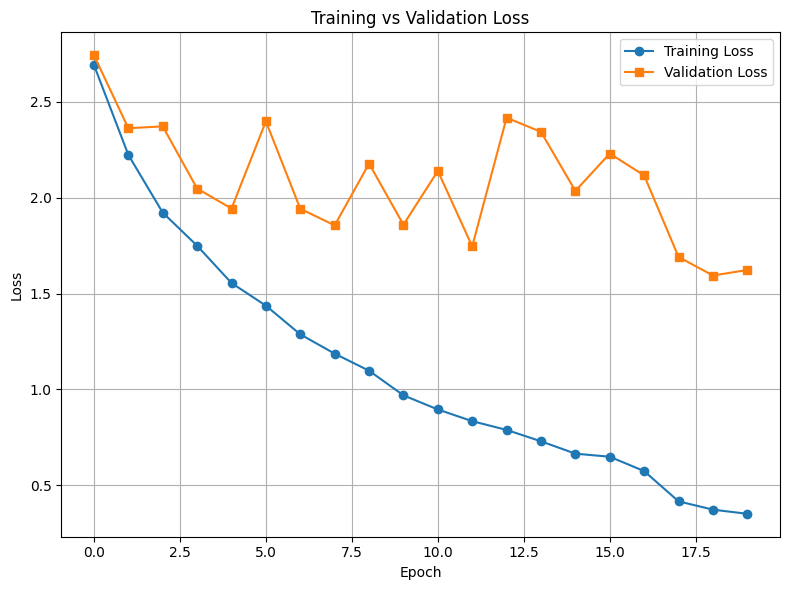

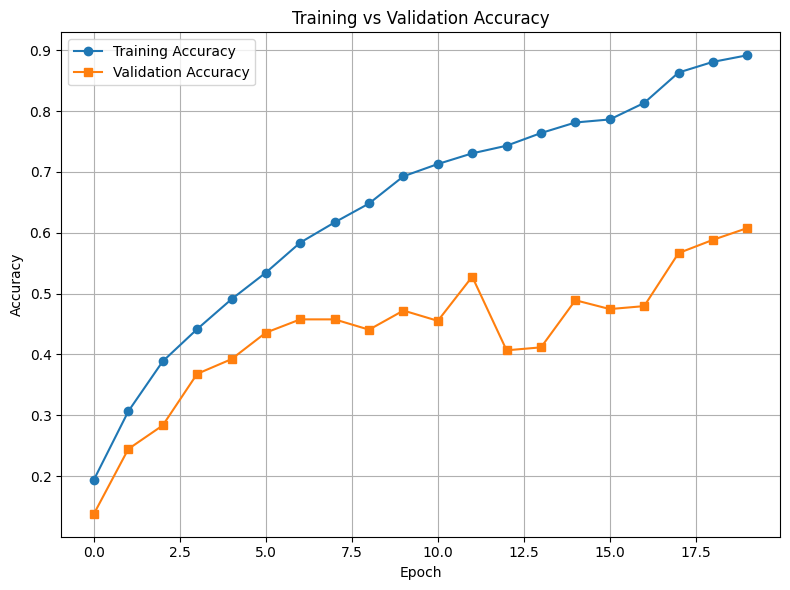

6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 992ms/step - accuracy: 0.8336 - loss: 0.6389

✅ Test Accuracy: 0.8391
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step 


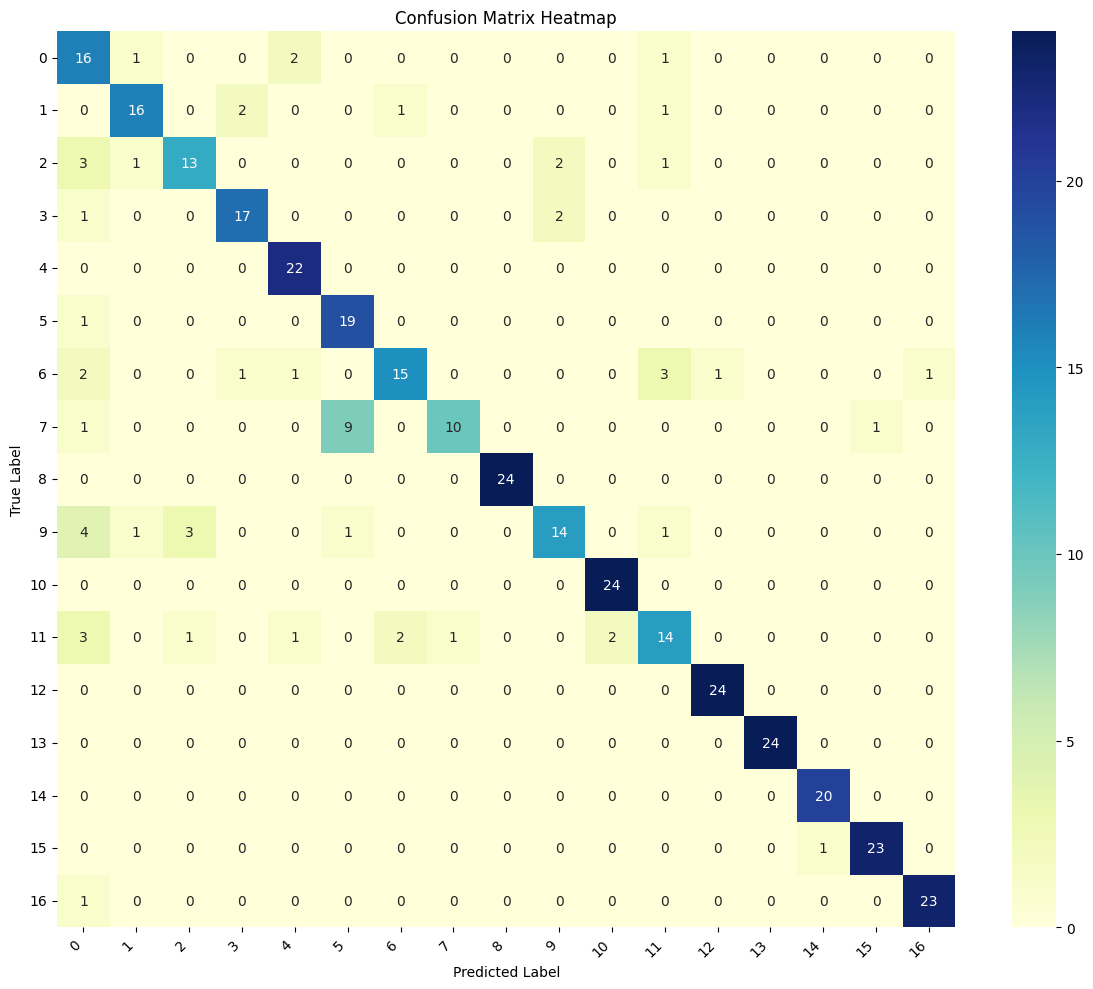


Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.80      0.62        20
           1       0.84      0.80      0.82        20
           2       0.76      0.65      0.70        20
           3       0.85      0.85      0.85        20
           4       0.85      1.00      0.92        22
           5       0.66      0.95      0.78        20
           6       0.83      0.62      0.71        24
           7       0.91      0.48      0.62        21
           8       1.00      1.00      1.00        24
           9       0.78      0.58      0.67        24
          10       0.92      1.00      0.96        24
          11       0.67      0.58      0.62        24
          12       0.96      1.00      0.98        24
          13       1.00      1.00      1.00        24
          14       0.95      1.00      0.98        20
          15       0.96      0.96      0.96        24
          16       0.96      0.96      0.96        24

 

In [7]:
#20 epochs
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report


os.makedirs("/kaggle/working/20epoch", exist_ok=True)


# --- Plot Training & Validation Loss ---
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("/kaggle/working/20epoch/training_validation_loss.png", dpi=300)
plt.show()

# --- Plot Training & Validation Accuracy ---
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("/kaggle/working/20epoch/training_validation_accuracy.png", dpi=300)
plt.show()

# --- Evaluate on test set ---
test_loss, test_acc = model2.evaluate(test_ds)
print(f"\n✅ Test Accuracy: {test_acc:.4f}")

# --- Collect predictions and true labels ---
y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_pred = np.concatenate([np.argmax(model2.predict(x), axis=1) for x, y in test_ds], axis=0)

# --- Confusion Matrix ---
cm = confusion_matrix(y_true, y_pred)
class_names = test_ds.class_names if hasattr(test_ds, 'class_names') else [str(i) for i in range(model2.output_shape[-1])]

# --- Colored Heatmap ---
plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix Heatmap")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig("/kaggle/working/20epoch/confusion_matrix_heatmap.png", dpi=300)
plt.show()

# --- Classification Report ---
report = classification_report(y_true, y_pred, target_names=class_names)
print("\nClassification Report:\n", report)

# --- Optionally save the text report as a file too ---
with open("/kaggle/working/20epoch/classification_report.txt", "w") as f:
    f.write(report)

print("\n✅ All plots and report saved in /kaggle/working/20epoch")


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Total misclassified samples: 61


/tmp/ipykernel_37/2034917189.py:56: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_37/2034917189.py:56: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_37/2034917189.py:60: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from current font.
  plt.savefig(output_path, dpi=300, bbox_inches='tight')
/tmp/ipykernel_37/2034917189.py:60: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from current font.
  plt.savefig(output_path, dpi=300, bbox_inches='tight')
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


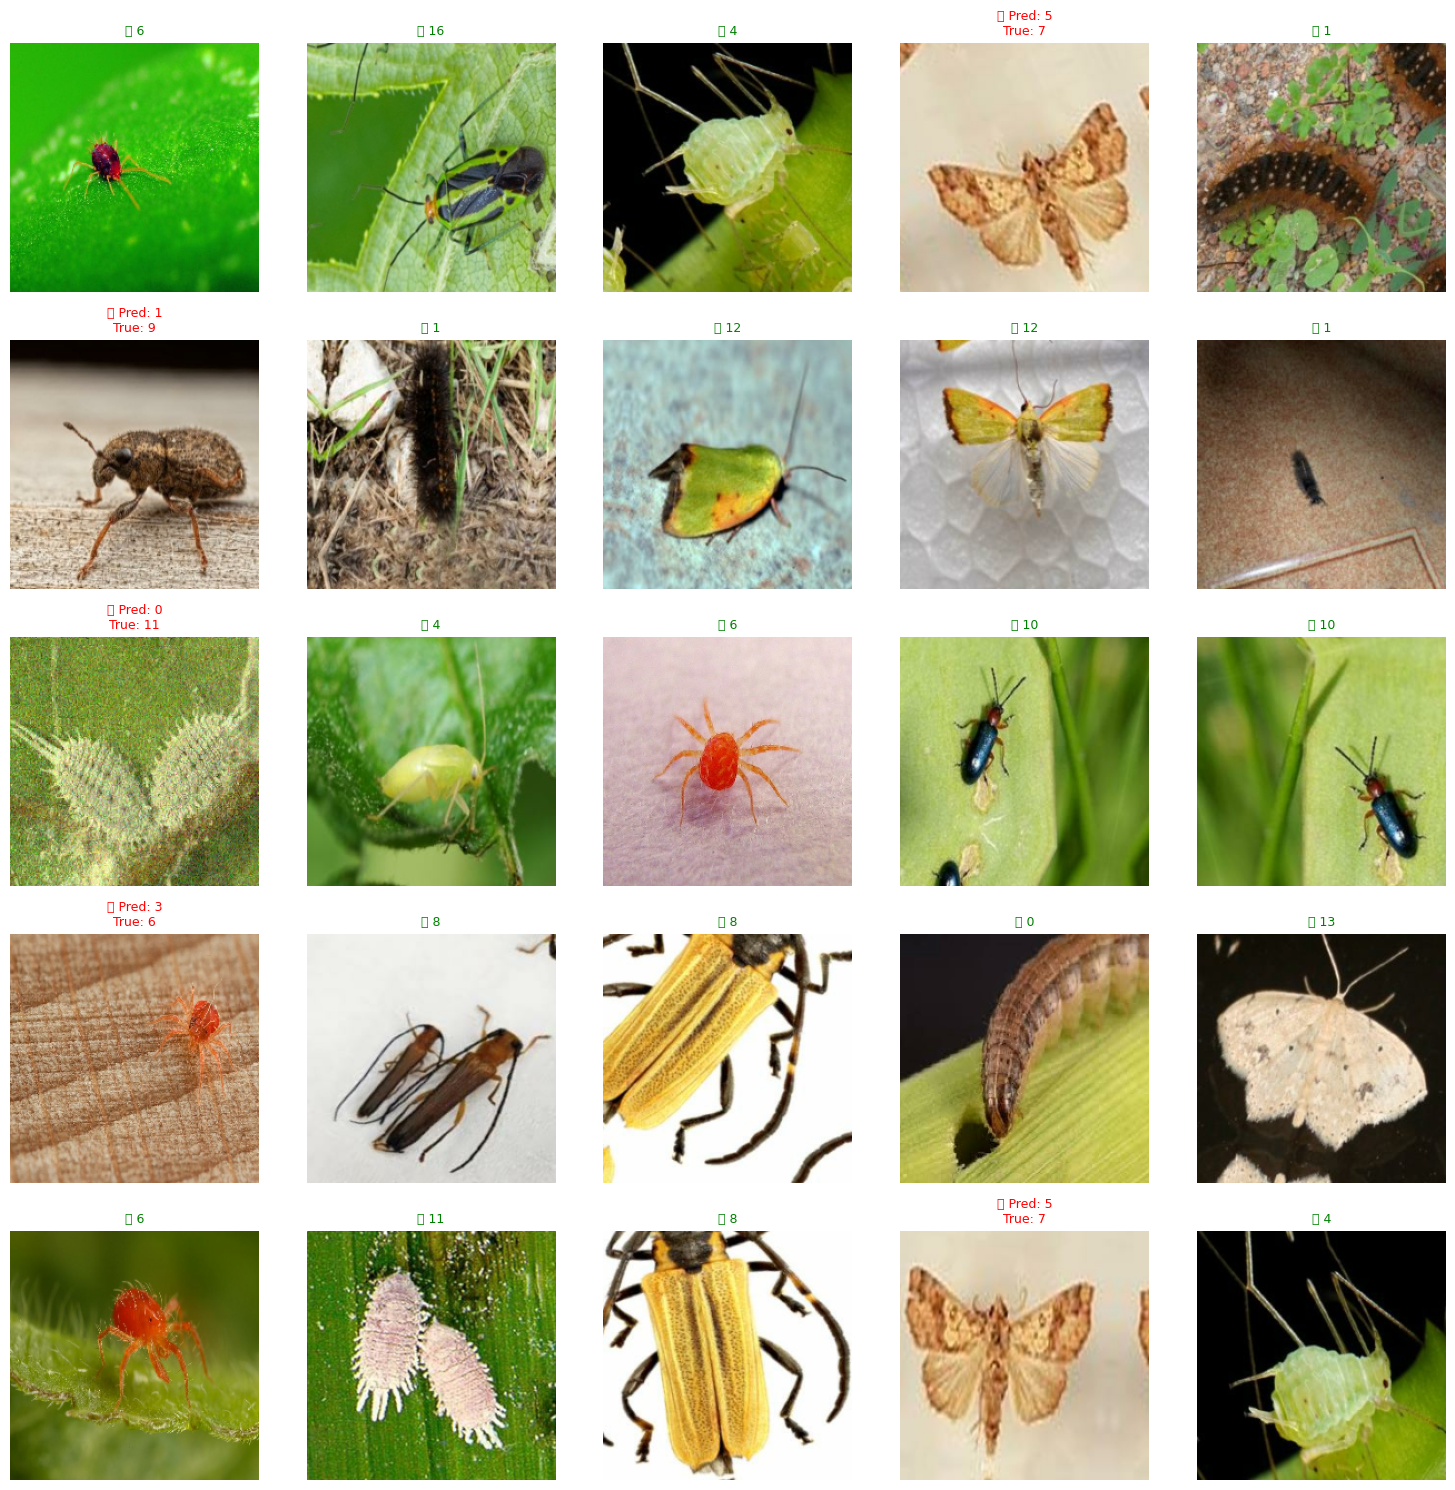

✅ Saved denormalized prediction results to: /kaggle/working/20epoch/prediction_results.png


In [8]:
# --- Define normalization constants (same as training) ---
mean = np.array([0.5546, 0.5501, 0.4272])
std = np.array([0.1865, 0.1920, 0.1956])

# --- Denormalization function ---
def denormalize(imgs):
    """Convert normalized images back to [0,1] range for display."""
    imgs = imgs * std + mean       # undo normalization
    imgs = np.clip(imgs, 0, 1)     # ensure values stay valid
    return imgs

# Assuming you already have test_ds and model2
class_names = test_ds.class_names if hasattr(test_ds, 'class_names') else [str(i) for i in range(model2.output_shape[-1])]

# --- Collect all images and labels from test_ds ---
images = []
labels = []
for x, y in test_ds:
    images.append(x.numpy())
    labels.append(y.numpy())
images = np.concatenate(images)
labels = np.concatenate(labels)

# --- Make predictions ---
pred_probs = model2.predict(images)
preds = np.argmax(pred_probs, axis=1)

# Find wrong predictions
wrong_indices = np.where(preds != labels)[0]
print(f"Total misclassified samples: {len(wrong_indices)}")

# --- Denormalize images for visualization ---
images_vis = denormalize(images)

# --- Plot predictions ---
num_images_to_show = 25  # change this to show more or less
plt.figure(figsize=(15, 15))

for i in range(num_images_to_show):
    plt.subplot(5, 5, i + 1)
    plt.imshow(images_vis[i])

    true_label = class_names[labels[i]]
    pred_label = class_names[preds[i]]

    if preds[i] == labels[i]:
        color = "green"
        title = f"✅ {pred_label}"
    else:
        color = "red"
        title = f"❌ Pred: {pred_label}\nTrue: {true_label}"

    plt.title(title, color=color, fontsize=9)
    plt.axis("off")

plt.tight_layout()

# --- Save the figure ---
output_path = "/kaggle/working/20epoch/prediction_results.png"
plt.savefig(output_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"✅ Saved denormalized prediction results to: {output_path}")


### Optimizer Comparison

In [10]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.utils.class_weight import compute_class_weight

# --- Dataset directories ---
train_dir = "/kaggle/input/jute-pest-dataset/Jute_Pest_Dataset/train"
val_dir = "/kaggle/input/jute-pest-dataset/Jute_Pest_Dataset/val"
test_dir = "/kaggle/input/jute-pest-dataset/Jute_Pest_Dataset/test"

# --- Load datasets ---
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=(224, 224),
    batch_size=64
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    image_size=(224, 224),
    batch_size=64
)
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(224, 224),
    batch_size=64
)

# --- Data Augmentation ---
data_augmentation = keras.Sequential([
    layers.RandomFlip(),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2)
])

train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

# --- Normalization ---
mean = [0.5546, 0.5501, 0.4272]
std = [0.1865, 0.1920, 0.1956]
rescale = layers.Rescaling(1./255)
normalize = layers.Normalization(mean=mean, variance=np.square(std))
_ = normalize(tf.zeros((1, 224, 224, 3)))  # initialize

def apply_normalization(x, y):
    x = rescale(x)
    x = normalize(x)
    return x, y

train_ds = train_ds.map(apply_normalization)
val_ds = val_ds.map(apply_normalization)
test_ds = test_ds.map(apply_normalization)

# --- Prefetch for performance ---
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

# --- Compute class weights to handle imbalance ---
all_labels = []
for _, y in train_ds.unbatch():
    all_labels.append(y.numpy())

labels_list = np.array(all_labels)

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(labels_list),
    y=labels_list
)

class_weights = dict(enumerate(class_weights))

# --- Define model builder ---
def build_custom_cnn(num_classes=17):
    model = models.Sequential([
        layers.Conv2D(32, (3,3), padding='same', input_shape=(224,224,3)),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D(2,2),

        layers.Conv2D(64, (3,3), padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D(2,2),

        layers.Conv2D(128, (3,3), padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D(2,2),

        layers.Conv2D(512, (3,3), padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D(2,2),

        layers.GlobalAveragePooling2D(),

        layers.Dense(256, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),

        layers.Dense(num_classes, activation='softmax')
    ])
    return model

# --- Optimizers to compare ---
optimizers_to_compare = {
    "Adam": optimizers.Adam(learning_rate=0.001),
    "SGD": optimizers.SGD(learning_rate=0.001),
    "SGD_Momentum": optimizers.SGD(learning_rate=0.001, momentum=0.9)
}

# --- Callbacks ---
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# --- Prepare result folders ---
base_dir = "/kaggle/working/optimizer_results"
os.makedirs(base_dir, exist_ok=True)

histories = {}
results = {}

# --- Train, Evaluate, and Save ---
for opt_name, opt in optimizers_to_compare.items():
    print(f"\n🔹 Training with {opt_name} optimizer...")

    opt_dir = os.path.join(base_dir, opt_name)
    os.makedirs(opt_dir, exist_ok=True)

    model = build_custom_cnn(num_classes= 17)
    model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=20,
        class_weight=class_weights,
        callbacks=[early_stop, reduce_lr],
        verbose=1
    )

    # Save history
    histories[opt_name] = history

    # Evaluate
    test_loss, test_acc = model.evaluate(test_ds)
    results[opt_name] = test_acc

    # --- Save plots ---
    plt.figure(figsize=(8,5))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{opt_name} - Loss Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(opt_dir, f'{opt_name}_loss.png'))
    plt.close()

    plt.figure(figsize=(8,5))
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{opt_name} - Accuracy Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(opt_dir, f'{opt_name}_accuracy.png'))
    plt.close()

    # Save model
    model.save(os.path.join(opt_dir, f'{opt_name}_model.h5'))

    print(f"✅ {opt_name} completed — Test accuracy = {test_acc:.4f}")




Found 6443 files belonging to 17 classes.
Found 413 files belonging to 17 classes.
Found 379 files belonging to 17 classes.

🔹 Training with Adam optimizer...
Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1761760363.358287     108 service.cc:148] XLA service 0x7b472c00c580 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1761760363.360813     108 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1761760363.360841     108 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1761760363.999873     108 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/101 ━━━━━━━━━━━━━━━━━━━━ 29:33 18s/step - accuracy: 0.0312 - loss: 3.9827

I0000 00:00:1761760375.499107     108 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 44/101 ━━━━━━━━━━━━━━━━━━━━ 11:59 13s/step - accuracy: 0.1224 - loss: 3.1714

2025-10-29 18:02:04.788100: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng4{k11=2} for conv (f32[64,128,31,32]{3,2,1,0}, u8[0]{0}) custom-call(f32[64,512,31,32]{3,2,1,0}, f32[512,128,3,3]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardInput", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2025-10-29 18:02:05.128503: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.34055409s
Trying algorithm eng4{k11=2} for conv (f32[64,128,31,32]{3,2,1,0}, u8[0]{0}) custom-call(f32[64,512,31,32]{3,2,1,0}, f32[512,128,3,3]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardInput", backend_config={"cudnn_conv_backend_config

 92/101 ━━━━━━━━━━━━━━━━━━━━ 1:53 13s/step - accuracy: 0.1468 - loss: 2.9881

2025-10-29 18:12:09.026574: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng4{k11=2} for conv (f32[64,128,30,32]{3,2,1,0}, u8[0]{0}) custom-call(f32[64,512,30,32]{3,2,1,0}, f32[512,128,3,3]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardInput", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2025-10-29 18:12:09.440724: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.414255258s
Trying algorithm eng4{k11=2} for conv (f32[64,128,30,32]{3,2,1,0}, u8[0]{0}) custom-call(f32[64,512,30,32]{3,2,1,0}, f32[512,128,3,3]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardInput", backend_config={"cudnn_conv_backend_confi

101/101 ━━━━━━━━━━━━━━━━━━━━ 1288s 13s/step - accuracy: 0.1501 - loss: 2.9628 - val_accuracy: 0.1114 - val_loss: 2.6347 - learning_rate: 0.0010
Epoch 2/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 15s 147ms/step - accuracy: 0.2551 - loss: 2.3427 - val_accuracy: 0.2228 - val_loss: 2.4466 - learning_rate: 0.0010
Epoch 3/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 15s 146ms/step - accuracy: 0.3103 - loss: 2.1192 - val_accuracy: 0.2276 - val_loss: 2.4532 - learning_rate: 0.0010
Epoch 4/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 15s 145ms/step - accuracy: 0.3848 - loss: 1.9258 - val_accuracy: 0.3027 - val_loss: 2.2468 - learning_rate: 0.0010
Epoch 5/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 15s 144ms/step - accuracy: 0.4455 - loss: 1.7587 - val_accuracy: 0.3584 - val_loss: 2.1800 - learning_rate: 0.0010
Epoch 6/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 15s 143ms/step - accuracy: 0.4880 - loss: 1.5868 - val_accuracy: 0.3995 - val_loss: 2.2969 - learning_rate: 0.0010
Epoch 7/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 15s 144ms/step - accuracy: 0.5503 - loss:

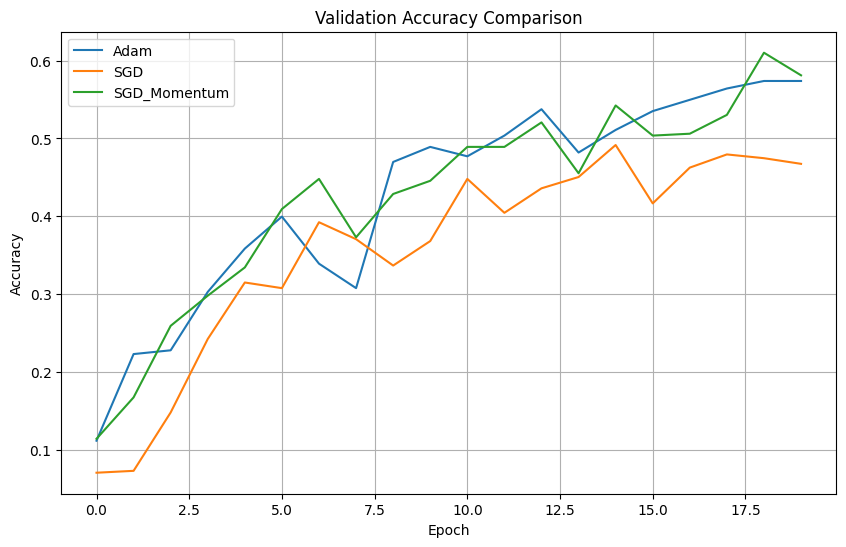

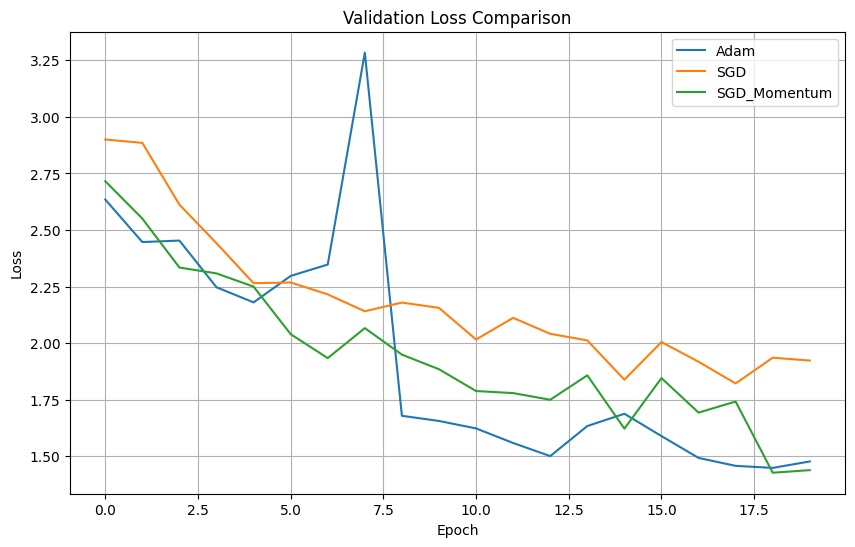


📁 All results saved in: /kaggle/working/optimizer_results


In [12]:
# --- Compare optimizers ---
plt.figure(figsize=(10,6))
for name, hist in histories.items():
    plt.plot(hist.history['val_accuracy'], label=f'{name}')
plt.title('Validation Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(base_dir, "comparison_accuracy.png"))
plt.show()
plt.close()

plt.figure(figsize=(10,6))
for name, hist in histories.items():
    plt.plot(hist.history['val_loss'], label=f'{name}')
plt.title('Validation Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(base_dir, "comparison_loss.png"))
plt.show()

plt.close()

print("\n📁 All results saved in:", base_dir)